In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import os
import cv2
import random
import json
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GroupKFold
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import efficientnet.tfkeras as efn
from tensorflow.keras.applications.densenet import DenseNet169, DenseNet121
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
print('tensorflow version:', tf.__version__)
try:
    print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
          '| device num:', os.environ['CUDA_VISIBLE_DEVICES'])
except:
    print('no env variable CUDA')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), 'physical GPUs,', len(logical_gpus), 'logical GPUs')
    except RuntimeError as e:
        print(e)

tensorflow version: 1.14.0
available GPU devices: 1 | device num: 0
1 physical GPUs, 1 logical GPUs


In [12]:
def seed_all(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_random_seed(seed)
seed_all(2020)
DATA_PATH = './data'
BATCH_SIZE = 4
FEATURES = True
N_FOLDS = 4
ADV_FEATURES = False
C_SIGMA, C_DELTA = tf.constant(70, dtype='float32'), tf.constant(1000, dtype='float32')
QS = [.15, .50, .85]
IMG_SIZE = 224
RESIZE = 224
SEQ_LEN = 6
MDL_VERSION = 'v0'
MODELS_PATH = '.'
LAMBDA = .8

In [3]:
train = pd.read_csv(f'{DATA_PATH}/train.csv')
train.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
test = pd.read_csv(f'{DATA_PATH}/test.csv')
subm = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
subm['Patient'] = subm['Patient_Week'].apply(lambda x: x.split('_')[0])
subm['Weeks'] = subm['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
subm =  subm[['Patient','Weeks','Confidence','Patient_Week']]
subm = subm.merge(test.drop('Weeks', axis=1), on='Patient')
train['SPLIT'] = 'train'
test['SPLIT'] = 'val'
subm['SPLIT'] = 'test'
data = train.append([test, subm])
print('train:',  train.shape, 'unique Pats:', train.Patient.nunique(),
      '\ntest:', test.shape,  'unique Pats:', test.Patient.nunique(),
      '\nsubm:', subm.shape,  'unique Pats:', subm.Patient.nunique(),
      '\ndata',  data.shape,  'unique Pats:', data.Patient.nunique())
data.head()

train: (1535, 8) unique Pats: 176 
test: (5, 8) unique Pats: 5 
subm: (730, 10) unique Pats: 5 
data (2270, 10) unique Pats: 176


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,SPLIT,Confidence,Patient_Week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN


In [4]:
data['min_week'] = data['Weeks']
data.loc[data.SPLIT == 'test', 'min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')
data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,SPLIT,Confidence,Patient_Week,min_week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,-4.0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,-4.0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,-4.0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,-4.0


In [5]:
data = pd.concat([data, pd.get_dummies(data.Sex), pd.get_dummies(data.SmokingStatus)], axis=1)
if FEATURES:
    base = data.loc[data.Weeks == data.min_week]
    base = base[['Patient', 'FVC']].copy()
    base.columns = ['Patient', 'min_week_FVC']
    base['nb'] = 1
    base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
    base = base[base.nb == 1]
    base.drop('nb', axis=1, inplace=True)
    data = data.merge(base, on='Patient', how='left')
    data['relative_week'] = data['Weeks'] - data['min_week']
    del base
if ADV_FEATURES:
    target_cols = [
        'FVC',
        'Percent',
        'min_week_FVC'
    ]
    enc_cols =  [ 
        'Female',
        'Male',
        'Currently smokes',
        'Ex-smoker',
        'Never smoked'
    ]
    for t_col in target_cols:
        for col in enc_cols:
            col_name = f'_{col}_{t_col}_'
            data[f'enc{col_name}mean'] = data.groupby(col)[t_col].transform('mean')
            data[f'enc{col_name}std'] = data.groupby(col)[t_col].transform('std')
    data['TC'] = 0
    data.loc[data['Weeks'] == 0, 'TC'] = 1
print(data.shape)
print(data.columns)
data.head()

(2270, 18)
Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus',
       'SPLIT', 'Confidence', 'Patient_Week', 'min_week', 'Female', 'Male',
       'Currently smokes', 'Ex-smoker', 'Never smoked', 'min_week_FVC',
       'relative_week'],
      dtype='object')


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,SPLIT,Confidence,Patient_Week,min_week,Female,Male,Currently smokes,Ex-smoker,Never smoked,min_week_FVC,relative_week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0,0,1,0,1,0,2315,0.0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,-4.0,0,1,0,1,0,2315,9.0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,-4.0,0,1,0,1,0,2315,11.0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,-4.0,0,1,0,1,0,2315,13.0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,-4.0,0,1,0,1,0,2315,15.0


In [6]:
feat_cols = [
    'Female', 'Male',
    'Currently smokes', 'Ex-smoker', 'Never smoked'
]
scale_cols = [
    'Percent', 
    'Age', 
    'relative_week', 
    'min_week_FVC'
]
scale_cols.extend([x for x in data.columns if 'FVC_mean' in x])
scaler = MinMaxScaler()
data[scale_cols] = scaler.fit_transform(data[scale_cols])
feat_cols.extend(scale_cols)
print('all data columns:', data.columns)

all data columns: Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus',
       'SPLIT', 'Confidence', 'Patient_Week', 'min_week', 'Female', 'Male',
       'Currently smokes', 'Ex-smoker', 'Never smoked', 'min_week_FVC',
       'relative_week'],
      dtype='object')


In [7]:
train = data.loc[data.SPLIT == 'train']
test = data.loc[data.SPLIT == 'val']
subm = data.loc[data.SPLIT == 'test']
del data

In [8]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,SPLIT,Confidence,Patient_Week,min_week,Female,Male,Currently smokes,Ex-smoker,Never smoked,min_week_FVC,relative_week
0,ID00007637202177411956430,-4,2315,0.236393,0.769231,Male,Ex-smoker,train,NaN,NaN,-4.0,0,1,0,1,0,0.241456,0.179012
1,ID00007637202177411956430,5,2214,0.215941,0.769231,Male,Ex-smoker,train,NaN,NaN,-4.0,0,1,0,1,0,0.241456,0.234568
2,ID00007637202177411956430,7,2061,0.184960,0.769231,Male,Ex-smoker,train,NaN,NaN,-4.0,0,1,0,1,0,0.241456,0.246914
3,ID00007637202177411956430,9,2144,0.201767,0.769231,Male,Ex-smoker,train,NaN,NaN,-4.0,0,1,0,1,0,0.241456,0.259259
4,ID00007637202177411956430,11,2069,0.186580,0.769231,Male,Ex-smoker,train,NaN,NaN,-4.0,0,1,0,1,0,0.241456,0.271605


In [22]:
class DataGenOsic(Sequence):
    def __init__(self, df, tab_cols,
                 batch_size=8, mode='fit', shuffle=False, 
                 aug=None, resize=None, seq_len=12, img_size=224):
        self.df = df
        self.shuffle = shuffle
        self.mode = mode
        self.aug = aug
        self.resize = resize
        self.batch_size = batch_size
        self.img_size = img_size
        self.seq_len = seq_len
        self.tab_cols = tab_cols
        self.on_epoch_end()
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __getitem__(self, index):
        batch_size = min(self.batch_size, len(self.df) - index * self.batch_size)
        X_img = np.zeros((batch_size, self.seq_len, self.img_size, self.img_size, 3), dtype=np.float32)
        X_tab = self.df[index * self.batch_size : (index + 1) * self.batch_size][self.tab_cols].values
        pats_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['Patient'].values
        for i, pat_id in enumerate(pats_batch):
            imgs_seq = self.get_imgs_seq(pat_id)
            X_img[i, ] = imgs_seq
        if self.mode == 'fit':
            y = np.array(
                self.df[index * self.batch_size : (index + 1) * self.batch_size]['FVC'].values, 
                dtype=np.float32
            )
            return (X_img, X_tab), y
        elif self.mode == 'predict':
            y = np.zeros(batch_size, dtype=np.float32)
            return (X_img, X_tab), y
        else:
            raise AttributeError('mode parameter error')
    def load_scan(self, pat_id):
        if self.mode == 'fit':
            path = f'{DATA_PATH}/train/{pat_id}'
        elif self.mode == 'predict':
            path = f'{DATA_PATH}/test/{pat_id}'
        else:
            raise AttributeError('mode parameter error')
        file_names = sorted(os.listdir(path), key=lambda x: int(os.path.splitext(x)[0]))
        slices = [
            pydicom.read_file(
                path + '/' + file_names[int(i * len(file_names) / self.seq_len)]
            )
            for i in range(self.seq_len)
        ]    
        if len(slices) < self.seq_len:
            for i in range(self.seq_len - len(slices)):
                slices.append(
                    pydicom.read_file(path + '/' + os.listdir(path)[-1])
                )
        return slices
    def get_pixels_hu(self, scans):
        image = np.stack([s.pixel_array.astype(float) for s in scans])
        image = image.astype(np.int16)
        image[image == -2000] = 0
        intercept = scans[0].RescaleIntercept
        slope = scans[0].RescaleSlope
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
        image += np.int16(intercept)
        return np.array(image, dtype=np.int16)
    def get_imgs_seq(self, pat_id):
        seq_imgs = []
        slices = self.load_scan(pat_id)
        scans = self.get_pixels_hu(slices)
        for img_idx in range(self.seq_len):
            img = scans[img_idx]
            if self.resize:
                img = cv2.resize(img, (self.resize, self.resize))
            img = (img - np.min(img)) / (np.max(img) - np.min(img))
            img = np.repeat(img[..., np.newaxis], 3, -1)
            seq_imgs.append(img)                 
        return np.array(seq_imgs).astype(np.float32)

In [10]:
gkf = GroupKFold(n_splits=N_FOLDS)
train['fold'] = -1
for i, (train_idx, val_idx) in enumerate(gkf.split(train, groups=train['Patient'])):
    train.loc[val_idx, 'fold'] = i
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,SPLIT,Confidence,Patient_Week,min_week,Female,Male,Currently smokes,Ex-smoker,Never smoked,min_week_FVC,relative_week,fold
0,ID00007637202177411956430,-4,2315,0.236393,0.769231,Male,Ex-smoker,train,NaN,NaN,-4.0,0,1,0,1,0,0.241456,0.179012,1
1,ID00007637202177411956430,5,2214,0.215941,0.769231,Male,Ex-smoker,train,NaN,NaN,-4.0,0,1,0,1,0,0.241456,0.234568,1
2,ID00007637202177411956430,7,2061,0.184960,0.769231,Male,Ex-smoker,train,NaN,NaN,-4.0,0,1,0,1,0,0.241456,0.246914,1
3,ID00007637202177411956430,9,2144,0.201767,0.769231,Male,Ex-smoker,train,NaN,NaN,-4.0,0,1,0,1,0,0.241456,0.259259,1
4,ID00007637202177411956430,11,2069,0.186580,0.769231,Male,Ex-smoker,train,NaN,NaN,-4.0,0,1,0,1,0,0.241456,0.271605,1


In [11]:
train_datagen = DataGenOsic(
    df=train.loc[train['fold'] != 0], 
    tab_cols=feat_cols,
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=True, 
    aug=None, 
    resize=RESIZE,
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE
)
val_datagen = DataGenOsic(
    df=train.loc[train['fold'] == 0],
    tab_cols=feat_cols,
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=False, 
    aug=None,
    resize=RESIZE,
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE
)

test X img:  (4, 6, 224, 224, 3)
test X tab:  (4, 9)
test y:  (4,)


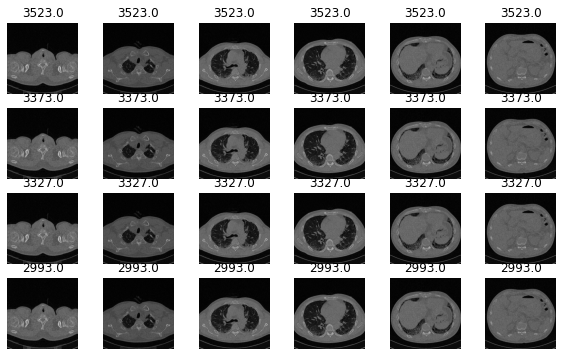

[3523. 3373. 3327. 2993.]
CPU times: user 1.08 s, sys: 164 ms, total: 1.24 s
Wall time: 1.97 s


In [12]:
%%time
(Xt_img, Xt_tab), yt = val_datagen.__getitem__(0)
print('test X img: ', Xt_img.shape)
print('test X tab: ', Xt_tab.shape)
print('test y: ', yt.shape)
fig, axes = plt.subplots(figsize=(10, 6), nrows=BATCH_SIZE, ncols=SEQ_LEN)
for j in range(BATCH_SIZE):
    for i in range(SEQ_LEN):
        axes[j, i].imshow(Xt_img[j][i])
        axes[j, i].axis('off')
        axes[j, i].set_title(yt[j])
plt.show()
print(yt)

In [11]:
def metric(y_true, y_pred, pred_std):
    clip_std = np.clip(pred_std, 70, 9e9)  
    delta = np.clip(np.abs(y_true - y_pred), 0 , 1000)  
    return np.mean(-1 * (np.sqrt(2) * delta / clip_std) - np.log(np.sqrt(2) * clip_std))
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    sigma_clip = tf.maximum(sigma, C_SIGMA)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C_DELTA)
    sq2 = tf.sqrt(tf.dtypes.cast(2, dtype=tf.float32))
    metric = sq2 * (delta / sigma_clip) * sq2 + tf.math.log(sigma_clip * sq2)
    return K.mean(metric)
def qloss(y_true, y_pred):
    q = tf.constant(np.array([QS]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q * e, (q - 1) * e)
    return K.mean(v)
def mloss(lmbd):
    def loss(y_true, y_pred):
        return lmbd * qloss(y_true, y_pred) + (1 - lmbd) * score(y_true, y_pred)
    return loss
def get_model(inputs_seq_shape, inputs_tab_shape, units=128, prob=.4, lmbd=.8):
    bottleneck = efn.EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
    bottleneck = M.Model(inputs=bottleneck.inputs, outputs=bottleneck.layers[-2].output)
    inputs_seq = L.Input(shape=(*inputs_seq_shape, ))
    inputs_tab = L.Input(shape=(inputs_tab_shape, ))
    x = L.TimeDistributed(bottleneck)(inputs_seq) 
    x = L.TimeDistributed(L.BatchNormalization())(x)
    x = L.GlobalMaxPooling3D()(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(prob)(x)
    x = L.Dense(4 * units, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(prob)(x)
    x = L.Dense(units, activation='relu')(x)
    comb_inputs = L.concatenate([inputs_tab, x])
    x = L.Dense(units, activation='relu')(comb_inputs)
    x = L.Dropout(prob)(x)
    x = L.Dense(units, activation='relu')(x)
    x = L.Dropout(prob)(x)
    preds = L.Dense(3, activation='linear')(x)
    model = M.Model([inputs_seq, inputs_tab], preds)
    model.compile(
        loss=mloss(lmbd),
        optimizer=Adam(lr=0.01), 
        metrics=[score]
    )
    return model

In [14]:
model_file = f'{MODELS_PATH}/model_{MDL_VERSION}.h5'
EPOCHS = 100
earlystopper = EarlyStopping(
        monitor='val_score', 
        patience=10, 
        verbose=0,
        mode='min'
        )
modelsaver = ModelCheckpoint(
    model_file, 
    monitor='val_score', 
    verbose=1, 
    save_best_only=True,
    mode='min'
)
lrreducer = ReduceLROnPlateau(
    monitor='val_score',
    factor=.1,
    patience=5,
    verbose=0,
    min_lr=1e-5,
    mode='min'
)
model = get_model(
    inputs_seq_shape=(SEQ_LEN, IMG_SIZE, IMG_SIZE, 3), 
    inputs_tab_shape=len(feat_cols), 
    units=128, prob=0, lmbd=LAMBDA
)
history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    callbacks=[earlystopper, modelsaver, lrreducer],
    verbose=1
)

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


286/287 [============================>.] - ETA: 1s - loss: 267.2610 - score: 9.1104
Epoch 00001: val_score improved from inf to 8.77636, saving model to ./model_v0.h5
287/287 [==============================] - 564s 2s/step - loss: 267.2246 - score: 9.1098 - val_loss: 331.6889 - val_score: 8.7764
Epoch 2/100
286/287 [============================>.] - ETA: 1s - loss: 200.9987 - score: 8.4584
Epoch 00002: val_score improved from 8.77636 to 8.23340, saving model to ./model_v0.h5
287/287 [==============================] - 539s 2s/step - loss: 200.8949 - score: 8.4585 - val_loss: 150.3230 - val_score: 8.2334
Epoch 3/100
286/287 [============================>.] - ETA: 1s - loss: 157.0251 - score: 8.2529
Epoch 00003: val_score improved from 8.23340 to 8.00113, saving model to ./model_v0.h5
287/287 [==============================] - 525s 2s/step - loss: 156.7494 - score: 8.2512 - val_loss: 106.6820 - val_score: 8.0011
Epoch 4/100
286/287 [============================>.] - ETA: 1s - loss: 95.281

287/287 [==============================] - 586s 2s/step - loss: 39.9361 - score: 6.9074 - val_loss: 41.7436 - val_score: 6.9965
Epoch 30/100
286/287 [============================>.] - ETA: 1s - loss: 39.8152 - score: 6.9071
Epoch 00030: val_score did not improve from 6.99648
287/287 [==============================] - 598s 2s/step - loss: 39.7727 - score: 6.9065 - val_loss: 42.0725 - val_score: 7.0055
Epoch 31/100
286/287 [============================>.] - ETA: 1s - loss: 39.7512 - score: 6.9112
Epoch 00031: val_score did not improve from 6.99648
287/287 [==============================] - 670s 2s/step - loss: 39.6986 - score: 6.9100 - val_loss: 41.6698 - val_score: 6.9984
Epoch 32/100
286/287 [============================>.] - ETA: 1s - loss: 39.7566 - score: 6.9141
Epoch 00032: val_score did not improve from 6.99648
287/287 [==============================] - 606s 2s/step - loss: 39.7968 - score: 6.9157 - val_loss: 41.8682 - val_score: 7.0021
Epoch 33/100
286/287 [======================

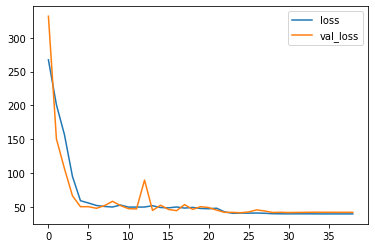

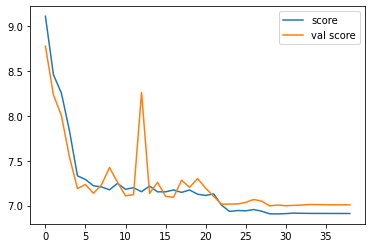

In [21]:
history_file = f'{MODELS_PATH}/history_{MDL_VERSION}.txt'
dict_to_save = {}
for k, v in history.history.items():
    dict_to_save.update({k: [np.format_float_positional(x) for x in history.history[k]]})
with open(history_file, 'w') as file:
    json.dump(dict_to_save, file)
ep_max = EPOCHS
plt.plot(history.history['loss'][:ep_max], label='loss')
plt.plot(history.history['val_loss'][:ep_max], label='val_loss')
plt.legend()
plt.show()
plt.plot(history.history['score'][:ep_max], label='score')
plt.plot(history.history['val_score'][:ep_max], label='val score')
plt.legend()
plt.show()

In [13]:
%%time
model_file = f'{MODELS_PATH}/model_{MDL_VERSION}.h5'
model = load_model(model_file, custom_objects={'qloss': qloss, 'loss': mloss(LAMBDA), 'score': score})
print('model loaded:', model_file)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
model loaded: ./model_v0.h5
CPU times: user 15.8 s, sys: 480 ms, total: 16.2 s
Wall time: 17 s


In [23]:
%%time
BATCH_SIZE_PRED = 2
subm_datagen = DataGenOsic(
    df=subm,
    tab_cols=feat_cols,
    batch_size=BATCH_SIZE_PRED,
    mode='predict', 
    shuffle=False, 
    aug=None,
    resize=RESIZE,
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE
)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 61.5 µs


test X img:  (2, 6, 224, 224, 3)
test X tab:  (2, 9)
test y:  (2,)


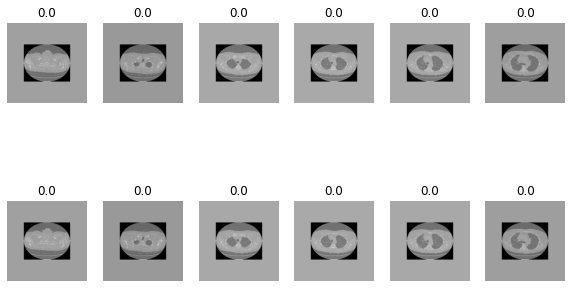

[0. 0.]
CPU times: user 304 ms, sys: 44 ms, total: 348 ms
Wall time: 390 ms


In [24]:
(Xt_img, Xt_tab), _ = subm_datagen.__getitem__(0)
print('val X img: ', Xt_img.shape)
print('val X tab: ', Xt_tab.shape)
fig, axes = plt.subplots(figsize=(10, 4), nrows=BATCH_SIZE_PRED, ncols=SEQ_LEN)
for j in range(BATCH_SIZE_PRED):
    for i in range(SEQ_LEN):
        if BATCH_SIZE_PRED > 1:
            axes[j, i].imshow(Xt_img[j][i])
            axes[j, i].axis('off')
            axes[j, i].set_title(f'{j + 1} of {BATCH_SIZE_PRED}')
        else:
            axes[i].imshow(Xt_img[j][i])
            axes[i].axis('off')
            axes[i].set_title(f'{j + 1} of {BATCH_SIZE_PRED}')
plt.show()

In [25]:
%%time
preds_subm = model.predict_generator(subm_datagen, verbose=1)
print('predictions shape:', preds_subm.shape)
print('predictions sample:', preds_subm[0])

365/365 [==============================] - 26s 72ms/step
(730, 3)
CPU times: user 29.6 s, sys: 5.03 s, total: 34.6 s
Wall time: 27 s


array([[2703.1172, 2875.835 , 3028.0354],
       [2701.1702, 2873.8267, 3025.922 ],
       [2699.2227, 2871.818 , 3023.8088],
       ...,
       [2375.1736, 2535.717 , 2670.195 ],
       [2373.2607, 2533.748 , 2668.1223],
       [2371.3481, 2531.7788, 2666.0496]], dtype=float32)

In [ ]:
subm['FVC'] = preds_subm[:, 1]
subm['Confidence'] = preds_subm[:, 2] - preds_subm[:, 0]
subm[['Patient_Week','FVC','Confidence']].to_csv('submission.csv', index=False)
subm[['Patient_Week','FVC','Confidence']].describe().T